In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import seaborn as sns
from datetime import datetime
from scipy import stats
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import FixedLocator, MaxNLocator
import math

plt.style.use('seaborn-v0_8-whitegrid')

In [2]:
import os
import sys

root_folder = os.path.dirname(os.path.abspath(os.getcwd()))
fetching_data_module_folder = root_folder + "\\fetch_data"

sys.path.insert(0, fetching_data_module_folder)

from fetching_satellite_based import remote_sensing_factor_df

In [3]:
begin_year = 2015
end_year = 2022

ndvi_df = remote_sensing_factor_df(factor='NDVI', begin=begin_year, end=end_year)

ndvi_df

,lon,lat,date,ID,NDVI
0,105.850899,21.021299,2015-01-01,5,0.194523
365,105.741867,21.049749,2015-01-01,19,0.326690
730,105.948544,21.200344,2015-01-01,51,0.373292
1095,106.288330,21.123247,2015-01-01,52,0.193489
1460,106.111371,21.152745,2015-01-01,53,0.198772
...,...,...,...,...,...
8029,106.314003,20.927000,2022-12-31,172,0.014728
8394,106.430801,20.977400,2022-12-31,173,0.016468
8759,106.385597,21.116400,2022-12-31,175,0.014485
9124,105.367302,21.338470,2022-12-31,195,0.005808


C:\Users\CA_UOP_MUOI\AppData\Local\Temp\ipykernel_19112\170049928.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  gap_cmap = plt.cm.get_cmap('Blues')


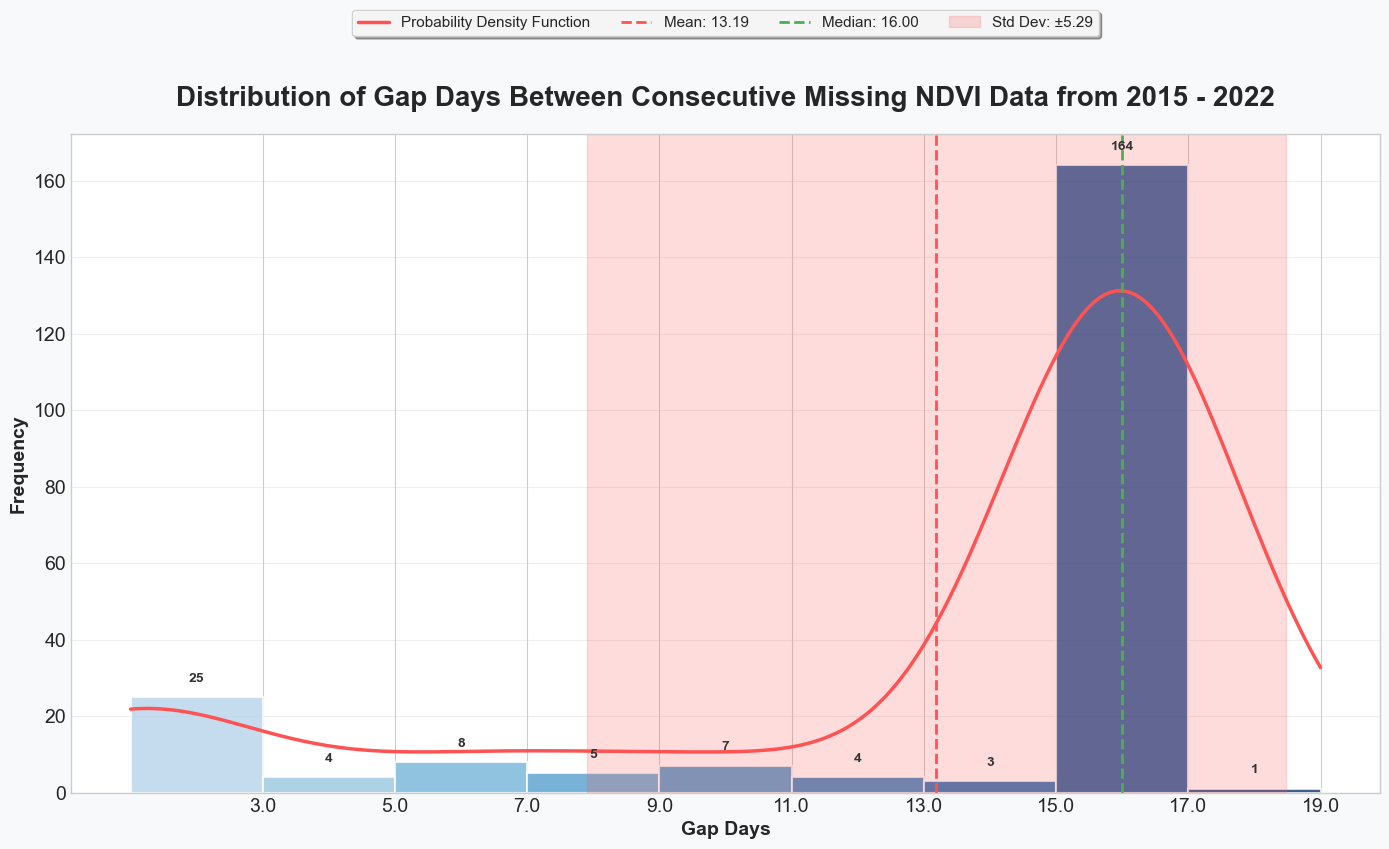

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
from datetime import datetime
from scipy import stats
from matplotlib.ticker import FixedLocator, MaxNLocator

plt.style.use('seaborn-v0_8-whitegrid')

tmp_ndvi_df = ndvi_df.loc[(ndvi_df['ID'] == 5) & (ndvi_df['date'] >= datetime.strptime("2001-01-01", "%Y-%m-%d"))].copy()

# Lấy các bản ghi mà NDVI là missing
df_missing = tmp_ndvi_df[tmp_ndvi_df['NDVI'].isnull()].copy()

# Tính khoảng cách (số ngày) giữa các bản ghi missing liên tiếp
df_missing['gap_days'] = df_missing['date'].diff().dt.days

# Lấy dữ liệu gap_days và loại bỏ giá trị NaN
gap_days_data = df_missing['gap_days'].dropna()

# Thiết lập figure với kích thước và nền phù hợp
plt.figure(figsize=(14, 8), facecolor='#f8f9fa')

# Tạo bins cho gap_days: sử dụng 10 bins dựa trên khoảng giá trị dữ liệu
bins = np.linspace(gap_days_data.min(), gap_days_data.max(), 10)

# Vẽ histogram cho gap_days
n, bins, patches = plt.hist(gap_days_data, bins=bins, 
                            alpha=0.8, edgecolor='white', linewidth=1.5)

# Tạo gradient màu cho các bins sử dụng colormap 'Blues'
gap_cmap = plt.cm.get_cmap('Blues')
bin_centers = 0.5 * (bins[:-1] + bins[1:])
col = (bin_centers - bin_centers.min()) / (bin_centers.max() - bin_centers.min())
for c, patch in zip(col, patches):
    plt.setp(patch, 'facecolor', gap_cmap(0.7 * c + 0.3))

# Thêm đường KDE (Kernel Density Estimation) cho gap_days
kde_xs = np.linspace(gap_days_data.min(), gap_days_data.max(), 200)
kde = stats.gaussian_kde(gap_days_data)
kde_values = kde(kde_xs)
scale_factor = n.max() / kde_values.max() * 0.8
plt.plot(kde_xs, kde_values * scale_factor, color='#FF5252', linewidth=2.5,
         label='Probability Density Function')

# Tính các chỉ số thống kê
mean_gap = gap_days_data.mean()
median_gap = gap_days_data.median()
std_gap = gap_days_data.std()

# Vẽ đường dọc cho Mean và Median
plt.axvline(mean_gap, color='#FF5252', linestyle='dashed', linewidth=2, 
            label=f'Mean: {mean_gap:.2f}')
plt.axvline(median_gap, color='#4CAF50', linestyle='dashed', linewidth=2, 
            label=f'Median: {median_gap:.2f}')

# Thêm vùng tô màu cho standard deviation
plt.axvspan(mean_gap - std_gap, mean_gap + std_gap, alpha=0.2, color='#FF5252',
            label=f'Std Dev: ±{std_gap:.2f}')

# Thiết lập tiêu đề và nhãn trục với phong cách hiện đại
plt.title(f'Distribution of Gap Days Between Consecutive Missing NDVI Data from {begin_year} - {end_year}', 
          fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Gap Days', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

# Đặt tick cho trục x tại vị trí bên phải của các bin
# Sử dụng bins[1:] làm vị trí tick
ax = plt.gca()
ax.xaxis.set_major_locator(FixedLocator(bins[1:]))
plt.xticks(bins[1:], [f'{edge:.1f}' for edge in bins[1:]], fontsize=14)
plt.yticks(fontsize=14)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.grid(axis='y', linestyle='-', alpha=0.3)

# Thêm nhãn số (tần số) ở trên mỗi cột của histogram
max_height = n.max()
for patch, height in zip(patches, n):
    if height > 0:
        plt.text(patch.get_x() + patch.get_width()/2, 
                 height + max_height * 0.02, 
                 str(int(height)), 
                 ha='center', va='bottom', fontsize=10, 
                 fontweight='bold', color='#333333')

# Legend đặt bên ngoài biểu đồ
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=4, 
           frameon=True, fancybox=True, shadow=True, fontsize=11, framealpha=0.9)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

C:\Users\CA_UOP_MUOI\AppData\Local\Temp\ipykernel_19112\4179201468.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  gap_cmap = plt.cm.get_cmap('Blues')
C:\Users\CA_UOP_MUOI\AppData\Local\Temp\ipykernel_19112\4179201468.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  gap_cmap = plt.cm.get_cmap('Blues')
C:\Users\CA_UOP_MUOI\AppData\Local\Temp\ipykernel_19112\4179201468.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  gap_cmap = plt.cm.get_cmap('Blues')
C:\Users\CA_U

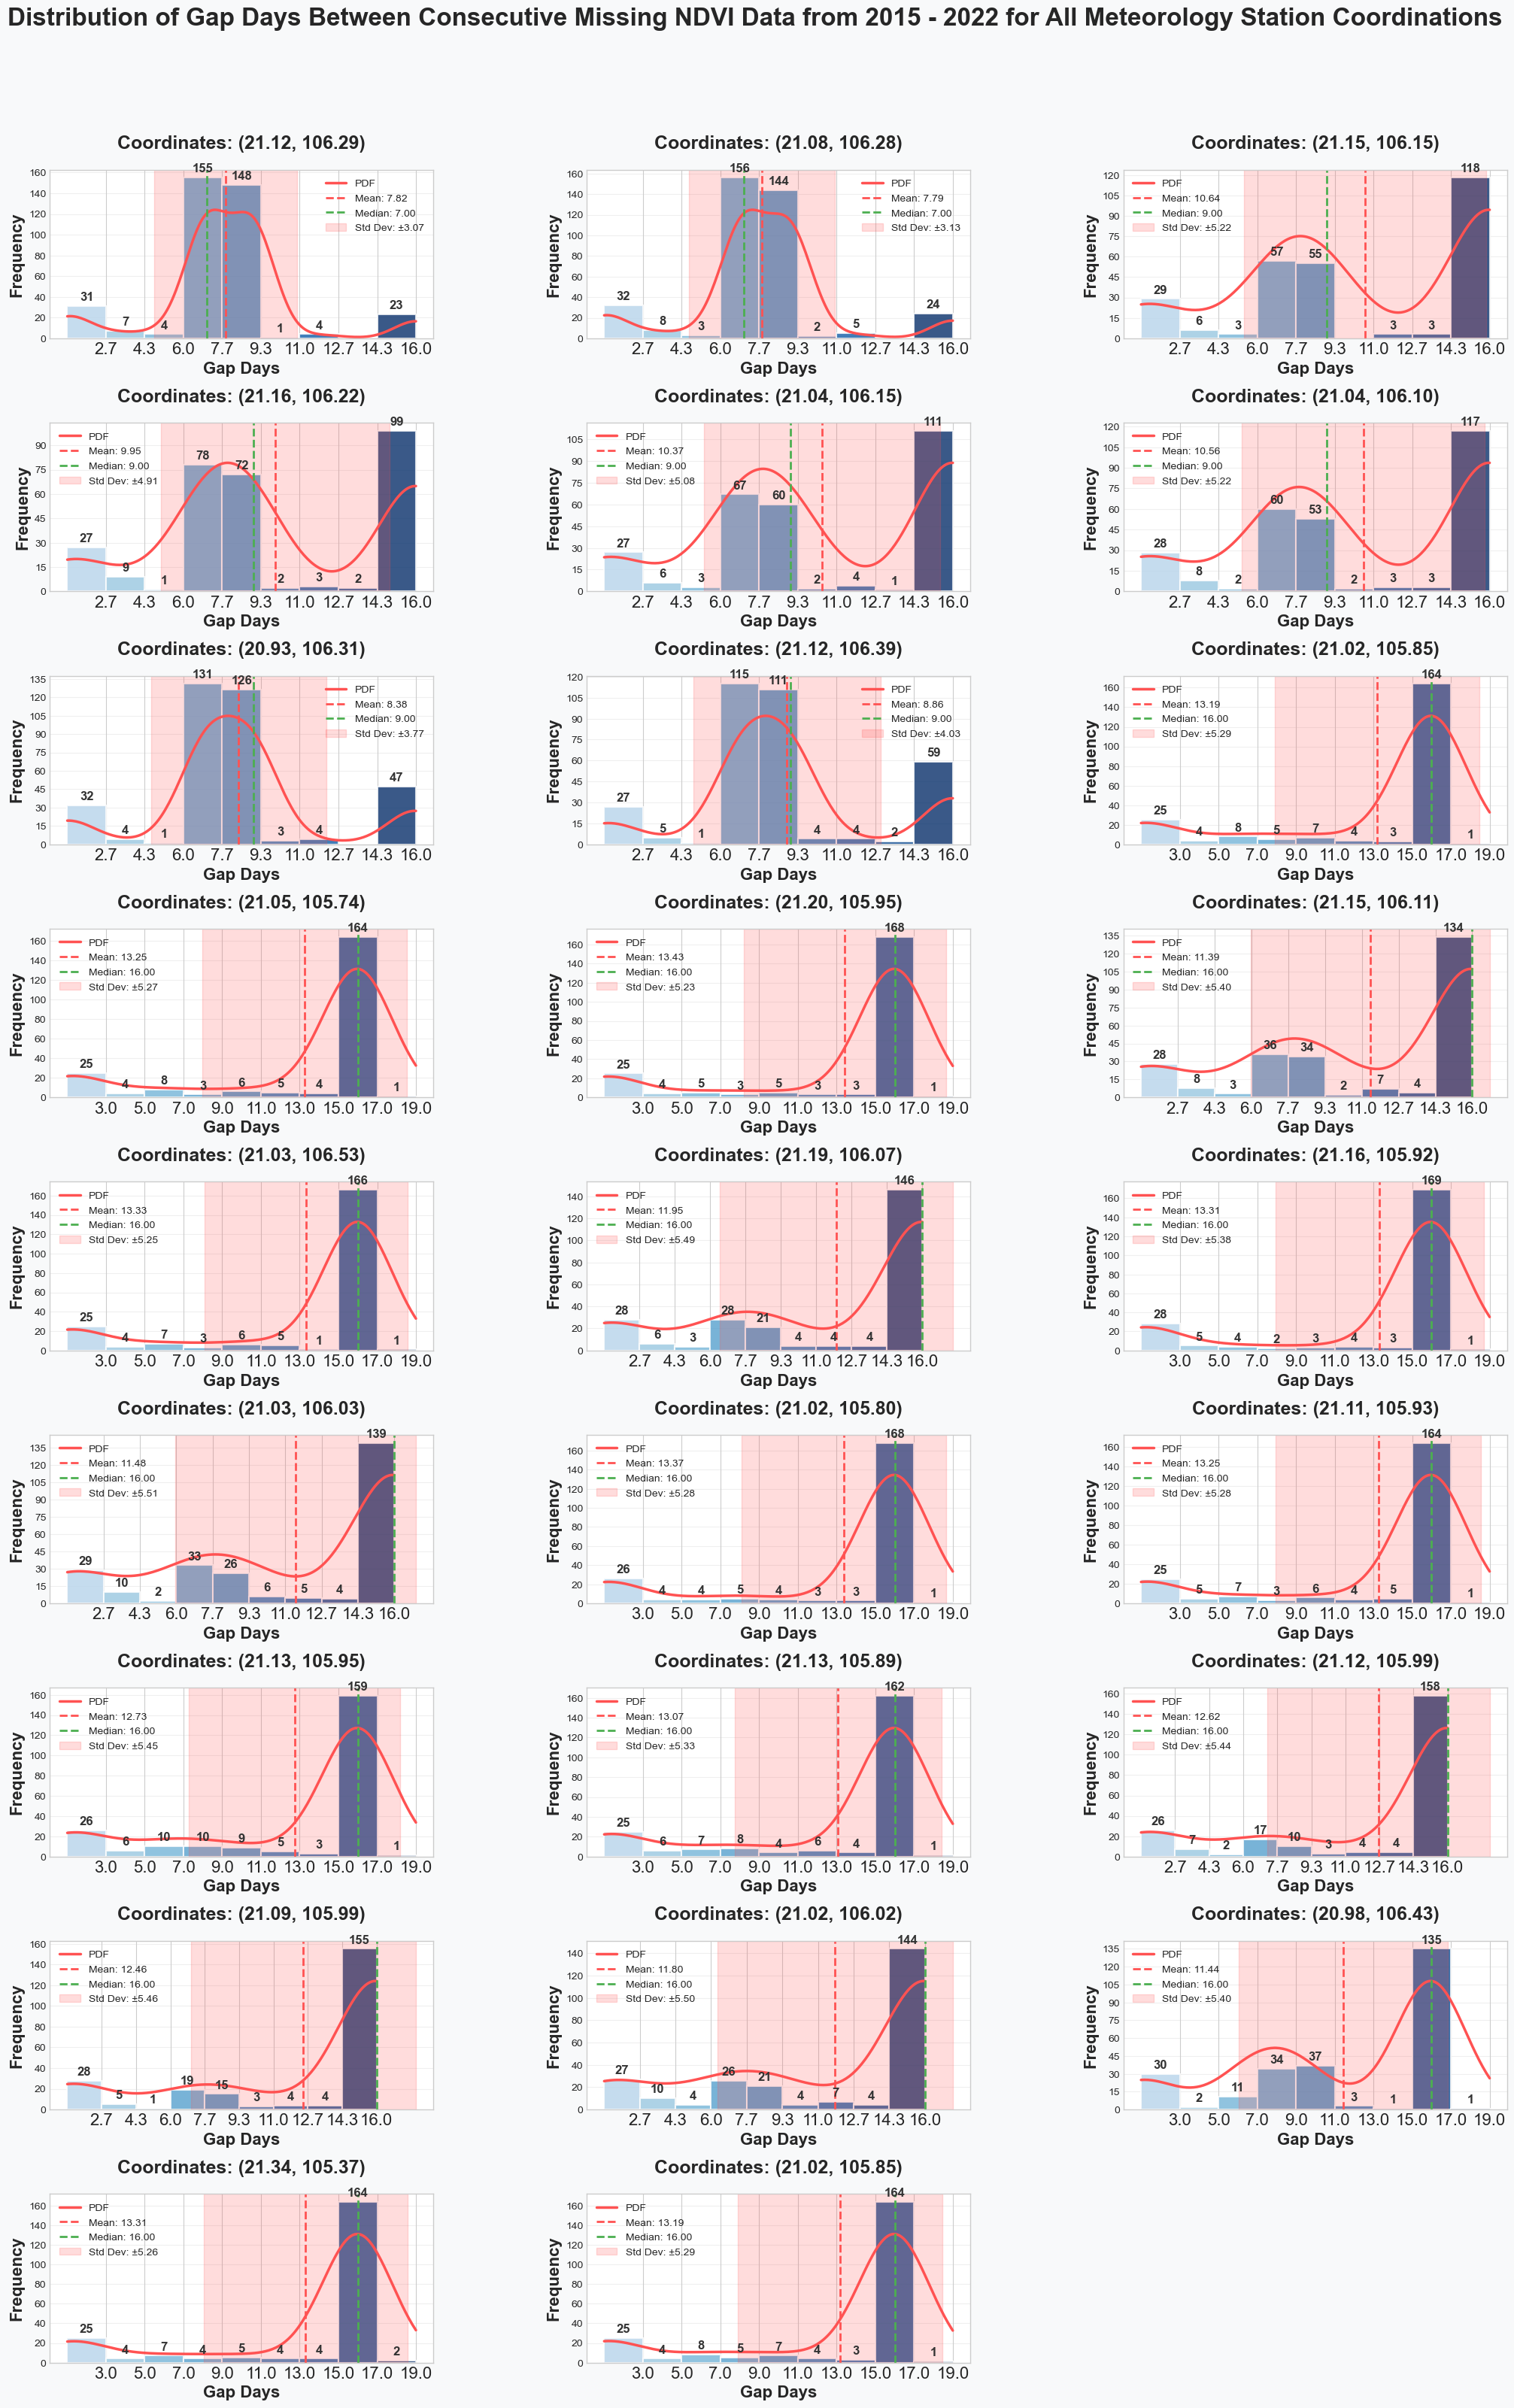

In [5]:
# Lấy danh sách các ID
id_list = sorted(ndvi_df['ID'].unique())

# Tạo một dict để lưu median gap cho các ID có đủ dữ liệu (≥2 missing)
median_dict = {}
for id_val in id_list:
    tmp = ndvi_df[ndvi_df['ID'] == id_val].copy()
    df_missing = tmp[tmp['NDVI'].isnull()].copy()
    if df_missing.shape[0] >= 2:
        df_missing['gap_days'] = df_missing['date'].diff().dt.days
        gap_data = df_missing['gap_days'].dropna()
        if not gap_data.empty:
            median_dict[id_val] = gap_data.median()

# Sắp xếp id_list theo giá trị median (IDs không có dữ liệu đủ sẽ được đặt sau)
sorted_ids = sorted(id_list, key=lambda i: median_dict.get(i, float('inf')))
id_list_sorted = sorted_ids
n_ids = len(id_list_sorted)

# Xếp mỗi hàng 3 plots
ncols = 3
nrows = math.ceil(n_ids / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25, nrows*4), facecolor='#f8f9fa')
axes = axes.flatten()

for ax, id_val in zip(axes, id_list_sorted):
    tmp = ndvi_df[ndvi_df['ID'] == id_val].copy()
    df_missing = tmp[tmp['NDVI'].isnull()].copy()
    
    if df_missing.shape[0] < 2:
        ax.text(0.5, 0.5, 'Not enough missing data', transform=ax.transAxes,
                ha='center', va='center', fontsize=14)
        # Nếu có thông tin tọa độ, hiển thị tọa độ; ngược lại, hiển thị ID
        if {'lat', 'lon'}.issubset(tmp.columns):
            lat_val = tmp['lat'].iloc[0]
            lon_val = tmp['lon'].iloc[0]
            ax.set_title(f'Coordinates: ({lat_val:.2f}, {lon_val:.2f})', fontsize=18, fontweight='bold', pad=20)
        else:
            ax.set_title(f'ID: {id_val}', fontsize=18, fontweight='bold', pad=20)
        continue
        
    df_missing['gap_days'] = df_missing['date'].diff().dt.days
    gap_data = df_missing['gap_days'].dropna()
    
    if gap_data.empty:
        ax.text(0.5, 0.5, 'No valid gap data', transform=ax.transAxes,
                ha='center', va='center', fontsize=14)
        if {'lat', 'lon'}.issubset(tmp.columns):
            lat_val = tmp['lat'].iloc[0]
            lon_val = tmp['lon'].iloc[0]
            ax.set_title(f'Coordinates: ({lat_val:.2f}, {lon_val:.2f})', fontsize=18, fontweight='bold', pad=20)
        else:
            ax.set_title(f'ID: {id_val}', fontsize=18, fontweight='bold', pad=20)
        continue
    
    # Vẽ histogram cho gap_data
    bins = np.linspace(gap_data.min(), gap_data.max(), 10)
    n, bins, patches = ax.hist(gap_data, bins=bins, alpha=0.8, edgecolor='white', linewidth=1.5)
    
    # Tạo gradient màu sử dụng colormap 'Blues'
    gap_cmap = plt.cm.get_cmap('Blues')
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    col = (bin_centers - bin_centers.min()) / (bin_centers.max() - bin_centers.min())
    for c, patch in zip(col, patches):
        patch.set_facecolor(gap_cmap(0.7 * c + 0.3))
    
    # Thêm đường KDE (Kernel Density Estimation)
    kde_xs = np.linspace(gap_data.min(), gap_data.max(), 200)
    kde = stats.gaussian_kde(gap_data)
    kde_values = kde(kde_xs)
    scale_factor = n.max() / kde_values.max() * 0.8
    ax.plot(kde_xs, kde_values * scale_factor, color='#FF5252', linewidth=2.5, label='PDF')
    
    # Tính các chỉ số thống kê
    mean_gap = gap_data.mean()
    median_gap = gap_data.median()
    std_gap = gap_data.std()
    
    # Vẽ các đường vẽ
    ax.axvline(mean_gap, color='#FF5252', linestyle='dashed', linewidth=2, label=f'Mean: {mean_gap:.2f}')
    ax.axvline(median_gap, color='#4CAF50', linestyle='dashed', linewidth=2, label=f'Median: {median_gap:.2f}')
    ax.axvspan(mean_gap - std_gap, mean_gap + std_gap, alpha=0.2, color='#FF5252', label=f'Std Dev: ±{std_gap:.2f}')
    
    # Nếu có thông tin tọa độ, hiển thị tọa độ; ngược lại hiển thị ID
    if {'lat', 'lon'}.issubset(tmp.columns):
        lat_val = tmp['lat'].iloc[0]
        lon_val = tmp['lon'].iloc[0]
        ax.set_title(f'Coordinates: ({lat_val:.2f}, {lon_val:.2f})', fontsize=18, fontweight='bold', pad=20)
    else:
        ax.set_title(f'ID: {id_val}', fontsize=18, fontweight='bold', pad=20)
        
    ax.set_xlabel('Gap Days', fontsize=16, fontweight='bold')
    ax.set_ylabel('Frequency', fontsize=16, fontweight='bold')
    
    # Đặt tick trục x ở vị trí bin bên phải (bins[1:])
    ax.xaxis.set_major_locator(FixedLocator(bins[1:]))
    ax.set_xticklabels([f'{edge:.1f}' for edge in bins[1:]], fontsize=16)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    
    ax.grid(axis='y', linestyle='-', alpha=0.3)
    
    max_height = n.max()
    for patch, height in zip(patches, n):
        if height > 0:
            ax.text(patch.get_x() + patch.get_width()/2, height + max_height * 0.02,
                    str(int(height)), ha='center', va='bottom', fontsize=12,
                    fontweight='bold', color='#333333')
    
    ax.legend(fontsize=10)

# Xóa các subplot thừa nếu có
for j in range(len(id_list_sorted), len(axes)):
    fig.delaxes(axes[j])
    
fig.subplots_adjust(top=0.92, hspace=0.5, wspace=0.4)
plt.suptitle(f'Distribution of Gap Days Between Consecutive Missing NDVI Data from {begin_year} - {end_year} for All Meteorology Station Coordinations', 
             fontsize=24, fontweight='bold', y=0.98)
plt.show()
